# Data exploration

In [1]:
import pandas as pd
import seaborn as sns

## Data import
The original dataset is > 2 million rows. This is too much data for my laptop to process at once, so as a data pre-processing step I have reduced this down to 50,000 rows by random sampling. 

An alternative approach to random sampling would be to eg. take all the loans issued in a chosen calendar year as the chosen sample. The issue with this approach is that we know from the client that "In the recent years, the share of defaulted loans issued on the platform has increased significantly" - so selecting loans from only a certain time period may introduce bias. 

In sampling this data I am assuming that each row represents a unique loan: ie. that a loan will not appear twice in the dataset with different loan_status values. As the id variable is anonymised as null in all cases this is a prudent assumption. 

Let's start by getting an overview of the shape of the data and the meaning of the columns: 

In [2]:
orig_df = pd.read_csv("../../data/processed/loan_sampled_50000.csv", low_memory = False)
df = orig_df.copy(deep = True)

In [3]:
df.shape

(50000, 145)

In [4]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,6200,6200,6200.0,36 months,10.41,201.26,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,19600,19600,19600.0,60 months,25.69,583.25,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,16000,16000,16000.0,60 months,11.99,355.84,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,16400,16400,16400.0,36 months,15.77,574.72,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,7100,7100,7100.0,36 months,14.49,244.36,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_data_dictionary = pd.read_excel("../../data/raw/LCDataDictionary.xlsx").dropna()

In [6]:
df_data_dictionary.style.set_properties(subset=["Description"], **{"width": "800px"})

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


## Add target variable 
As per the client:

Default client is defined as one with loan_status variable taking on the following levels:
- Charged off
- Default
- Does not meet the credit policy. Status: Charged Off
- Late (31-120 days)

We are left to construct our own definition for a non-default client. 

There are numerous approaches we could take on this:

1. Take all clients who do not meet the default definition as non-default. The drawback to this is that it includes clients in statuses that may later lead to default. A client in the status "current", "late (16-30 days)", or "in grace period" may later default on the loan: we have no way of predicting the future! 

2. Take all clients who we know have paid off their loan as non-default. From the business perspective this is the safer choice: we can guarantee the status of these clients and we are not introducing bias from customers that may default later. 

So, we define a non-default client as one with the loan_status variable taking on the following levels:
- Fully paid
- Does not meet the credit policy. Status: Fully paid 

What do we do with clients that are in an in-between state (ie. those we cannot name as a definite default or non-default)? Our task is to predict clients that default. Working on the hypothesis that there will be noticeable differences in characteristics between default and non-default clients, the dataset of clients that are neither will contain clients of both characteristics. To reduce any confusion this may introduce in the predictive stage - and for ease of analysis - we will simply remove these clients for now. 

In [7]:
default_client_values = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", 
                        "Late (31-120 days)"]
non_default_client_values = ["Fully Paid", "Does not meet the credit policy. Status:Fully Paid"]

In [8]:
df["loan_status"].value_counts()

Fully Paid                                             23164
Current                                                20335
Charged Off                                             5671
Late (31-120 days)                                       477
In Grace Period                                          212
Late (16-30 days)                                         79
Does not meet the credit policy. Status:Fully Paid        43
Does not meet the credit policy. Status:Charged Off       18
Default                                                    1
Name: loan_status, dtype: int64

In [9]:
def drop_inbetween_clients(df):
    target_values = default_client_values + non_default_client_values
    return df[df["loan_status"].isin(target_values)]

In [10]:
df = drop_inbetween_clients(df)
df.shape

(29374, 145)

By dropping the clients whose statuses we cannot infer, we reduce the size of our dataset by around 40%. 

Next, let's add the target variable. We'll say that a default client is 1 (the class we're trying to predict) and a non-default client is 0. 

In [11]:
def add_target_variable(df):
    df["target"] = df["loan_status"].isin(default_client_values)
    return df

In [12]:
df = add_target_variable(df)
df["target"].value_counts()

False    23207
True      6167
Name: target, dtype: int64

Adding the target variable, we can see we have a class imbalance: roughly 4x as many non-default clients as default. This may cause problems later: for now, let's continue with our data analysis. 

As an aside, since we're looking to predict if a loan will default *before* it is offered, we can safely drop the loan_status column now that we have encoded the default/non-default status in our target variable.

In [13]:
df.drop(columns=["loan_status"], inplace = True)

## Preprocessing

Before diving in to the characteristics of our data, let's take a look at the data quality in the dataframe, and perform data cleaning if required. 

Let's start by looking at the dtypes of our columns, and see if there are any columns we need to coerce into appropriate types. 

### Dtypes

Let's start by looking at what our dataframe dtypes look like. The obvious target will be 'object' columns - ones which pandas could not coerce into known types so is just treating as text.

We're most likely to have to convert to:

- Bool

- Date

- Categorical 

so we'll approach conversion in that order, then see what is left over. 

In [14]:
df.dtypes.value_counts()

float64    98
object     35
int64      11
bool        1
dtype: int64

In [15]:
pd.set_option('display.max_columns', 36)
df.select_dtypes('object').head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,desc,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,verification_status_joint,sec_app_earliest_cr_line,hardship_flag,hardship_type,hardship_reason,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date
0,36 months,B,B3,Desktop Services,1 year,RENT,Not Verified,Mar-2018,n,NaN,debt_consolidation,Debt consolidation,336xx,FL,Jan-2012,w,Feb-2019,NaN,Feb-2019,Individual,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
1,60 months,F,F1,Production Operator,9 years,MORTGAGE,Source Verified,Oct-2016,n,NaN,credit_card,Credit card refinancing,727xx,AR,Aug-1993,f,Mar-2017,NaN,Sep-2017,Individual,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
2,60 months,C,C1,Assistant Store Manager,1 year,MORTGAGE,Not Verified,Dec-2015,n,NaN,debt_consolidation,Debt consolidation,275xx,NC,Sep-1996,w,Nov-2018,NaN,Nov-2018,Individual,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
3,36 months,D,D1,Street Department,3 years,MORTGAGE,Not Verified,Dec-2015,n,NaN,credit_card,Credit card refinancing,548xx,WI,Mar-1997,w,Feb-2019,NaN,Jan-2019,Individual,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
4,36 months,C,C4,Assistant Head Housekeeper,2 years,RENT,Source Verified,Oct-2014,n,NaN,car,Car financing,054xx,VT,Mar-2010,f,Oct-2017,NaN,Aug-2018,Individual,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN


Let's first look over the columns that we can likely convert to boolean. To convert a column to boolean we'll want only two possible values in the column. 

In [16]:
df["pymnt_plan"].value_counts()

n    29363
y       11
Name: pymnt_plan, dtype: int64

In [17]:
df["initial_list_status"].value_counts()

w    17028
f    12346
Name: initial_list_status, dtype: int64

For initial_list_status, we will treat this as a boolean. According to (https://blog.lendingclub.com/investor-updates-and-enhancements/), this is 'whole' vs. 'fractional' so we will add a boolean column 'is_whole_loan'. 

In [18]:
df["application_type"].value_counts()

Individual    28817
Joint App       557
Name: application_type, dtype: int64

As with above, we'll add a boolean column 'is_individual_app'. 

In [19]:
df["hardship_flag"].value_counts()

N    29361
Y       13
Name: hardship_flag, dtype: int64

In [20]:
df["debt_settlement_flag"].value_counts()

N    28668
Y      706
Name: debt_settlement_flag, dtype: int64

In [21]:
df["term"].value_counts()

 36 months    22161
 60 months     7213
Name: term, dtype: int64

The term column is a bit tougher to decide. We could create a boolean column 'is_36_months', or we could create a column containing the loan term in months. For now - let's try both and see if one performs better than the other. 

In [22]:
df["disbursement_method"].value_counts()

Cash         29241
DirectPay      133
Name: disbursement_method, dtype: int64

In [23]:
df["verification_status"].value_counts()

Source Verified    11485
Verified            8998
Not Verified        8891
Name: verification_status, dtype: int64

This column has three possible values, so we can't convert it to a boolean. We can convert it to a categorial column, or use one-hot-encoding: let's decide later. 

In [24]:
df["hardship_status"].value_counts()

COMPLETED    96
BROKEN       64
ACTIVE       13
Name: hardship_status, dtype: int64

In [25]:
df["hardship_loan_status"].value_counts()

Late (16-30 days)     74
In Grace Period       60
Current               32
Late (31-120 days)     7
Name: hardship_loan_status, dtype: int64

In [26]:
df["settlement_status"].value_counts()

ACTIVE      334
COMPLETE    283
BROKEN       89
Name: settlement_status, dtype: int64

In [27]:
df["hardship_type"].value_counts()

INTEREST ONLY-3 MONTHS DEFERRAL    173
Name: hardship_type, dtype: int64

Having confirmed which columns can be converted to boolean (ie. there are only two possible values for the column), we can add the boolean columns and drop the original columns. To avoid unexpected coercion of values, let's check none are NaN first: 

In [28]:
for col in ["pymnt_plan", "initial_list_status", "application_type", 
                   "hardship_flag", "debt_settlement_flag", "term", "disbursement_method"]:
    print(col)
    print(df[col].isnull().sum())

pymnt_plan
0
initial_list_status
0
application_type
0
hardship_flag
0
debt_settlement_flag
0
term
0
disbursement_method
0


In [29]:
df["is_payment_plan"] = df["pymnt_plan"] == "y"
df["is_whole_loan"] = df["initial_list_status"] == "w"
df["is_individual_app"] = df["application_type"] == "Individual"
df["is_hardship"] = df["hardship_flag"] == "Y"
df["is_debt_settlement"] = df["debt_settlement_flag"] == "Y"
df["is_36_month_term"] = df["term"] == "36 months"
df["term_months"] = df["term"].str[1:3].astype(int)
df["is_cash"] = df["disbursement_method"] == "Cash"
df.drop(columns = ["pymnt_plan", "initial_list_status", "application_type", 
                   "hardship_flag", "debt_settlement_flag", "term", "disbursement_method"],
       inplace = True)

Having done booleans, let's now look at columns we can convert to dates.

In [30]:
df.select_dtypes('object').head()

,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,desc,purpose,title,zip_code,addr_state,earliest_cr_line,last_pymnt_d,next_pymnt_d,last_credit_pull_d,verification_status_joint,sec_app_earliest_cr_line,hardship_type,hardship_reason,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,debt_settlement_flag_date,settlement_status,settlement_date
0,B,B3,Desktop Services,1 year,RENT,Not Verified,Mar-2018,NaN,debt_consolidation,Debt consolidation,336xx,FL,Jan-2012,Feb-2019,NaN,Feb-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,F1,Production Operator,9 years,MORTGAGE,Source Verified,Oct-2016,NaN,credit_card,Credit card refinancing,727xx,AR,Aug-1993,Mar-2017,NaN,Sep-2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C,C1,Assistant Store Manager,1 year,MORTGAGE,Not Verified,Dec-2015,NaN,debt_consolidation,Debt consolidation,275xx,NC,Sep-1996,Nov-2018,NaN,Nov-2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D,D1,Street Department,3 years,MORTGAGE,Not Verified,Dec-2015,NaN,credit_card,Credit card refinancing,548xx,WI,Mar-1997,Feb-2019,NaN,Jan-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C,C4,Assistant Head Housekeeper,2 years,RENT,Source Verified,Oct-2014,NaN,car,Car financing,054xx,VT,Mar-2010,Oct-2017,NaN,Aug-2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Again, let's do a sanity check on how many values are NaN. In this case, we see that a few of the columns have a significant number of NaNs. By using the infer_datetime_format=True flag later, we'll make sure these are converted to NaT values. We will deal with these NaT values in the next part. 

In [31]:
for col in ["issue_d", "earliest_cr_line", "last_pymnt_d", "next_pymnt_d", "last_credit_pull_d",
           "hardship_start_date", "hardship_end_date", "payment_plan_start_date", 
            "debt_settlement_flag_date", "settlement_date", "sec_app_earliest_cr_line"]:
    print(col)
    print(df[col].isnull().sum())

issue_d
0
earliest_cr_line
0
last_pymnt_d
57
next_pymnt_d
28835
last_credit_pull_d
1
hardship_start_date
29201
hardship_end_date
29201
payment_plan_start_date
29201
debt_settlement_flag_date
28668
settlement_date
28668
sec_app_earliest_cr_line
28965


In [32]:
for col in ["issue_d", "earliest_cr_line", "last_pymnt_d", "next_pymnt_d", "last_credit_pull_d",
           "hardship_start_date", "hardship_end_date", "payment_plan_start_date", 
            "debt_settlement_flag_date", "settlement_date", "sec_app_earliest_cr_line"]:
    df[col] = pd.to_datetime(df[col], infer_datetime_format=True)

Finally, let's look at the columns we can convert to categorical columns. 

In [33]:
df.select_dtypes('object').head()

,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,desc,purpose,title,zip_code,addr_state,verification_status_joint,hardship_type,hardship_reason,hardship_status,hardship_loan_status,settlement_status
0,B,B3,Desktop Services,1 year,RENT,Not Verified,NaN,debt_consolidation,Debt consolidation,336xx,FL,NaN,NaN,NaN,NaN,NaN,NaN
1,F,F1,Production Operator,9 years,MORTGAGE,Source Verified,NaN,credit_card,Credit card refinancing,727xx,AR,NaN,NaN,NaN,NaN,NaN,NaN
2,C,C1,Assistant Store Manager,1 year,MORTGAGE,Not Verified,NaN,debt_consolidation,Debt consolidation,275xx,NC,NaN,NaN,NaN,NaN,NaN,NaN
3,D,D1,Street Department,3 years,MORTGAGE,Not Verified,NaN,credit_card,Credit card refinancing,548xx,WI,NaN,NaN,NaN,NaN,NaN,NaN
4,C,C4,Assistant Head Housekeeper,2 years,RENT,Source Verified,NaN,car,Car financing,054xx,VT,NaN,NaN,NaN,NaN,NaN,NaN


Let's start by looking at how many unique values there are in each column. Columns with too many values will be unsuitable for use as a categorical datatype - and are unlikely to be useful for prediction. 

In [34]:
for col in df.select_dtypes('object').columns:
    print(f"{col}:\t{df[col].nunique()}")

grade:	7
sub_grade:	35
emp_title:	15469
emp_length:	11
home_ownership:	5
verification_status:	3
desc:	2784
purpose:	14
title:	2384
zip_code:	851
addr_state:	50
verification_status_joint:	3
hardship_type:	1
hardship_reason:	9
hardship_status:	3
hardship_loan_status:	4
settlement_status:	3


From the above we can see that emp_title, desc, title, zip_code are too granular, so unlikely to be useful. hardship_type has only one value, but we can assume that it is a categorical variable, or may be a categorical variable in the future: the business may add new hardship types. 

In [35]:
for col in ["grade", "sub_grade", "home_ownership", 
           "verification_status", "purpose", 
           "addr_state", "verification_status_joint", 
           "hardship_type", "hardship_reason", "hardship_status",
           "hardship_loan_status", "settlement_status"]:
    df[col] = df[col].astype('category')

The emp_length column is a special case, as it represents employment length: being numerical, it makes more sense for this to be stored as a numerical column. We *could* convert this to a categorical column: or we could create a numerical column, with <1 year set as 0 and 10+ years set as 11. For ease of modelling, let's do the latter. 

In [36]:
df["emp_length"].value_counts()

10+ years    9742
2 years      2581
< 1 year     2393
3 years      2305
1 year       1938
5 years      1893
4 years      1764
8 years      1371
7 years      1270
6 years      1265
9 years      1154
Name: emp_length, dtype: int64

In [37]:
df["emp_length"] = df["emp_length"].replace({"10+ years": "11 years", "< 1 year": "0 years"})
df["emp_length"] = df["emp_length"].str[:2].astype('float')

Let's look at our remaining object columns:

In [38]:
for col in df.select_dtypes('object').columns:
    print(f"{col}:\t{df[col].nunique()}")

emp_title:	15469
desc:	2784
title:	2384
zip_code:	851


All these are unlikely to be useful due to their high level of granularity: let's drop them for now. There may be further avenues for exploration here in:

- Using NLP on the free-text columns

- Exploring zip_code correlation with loan default status on the larger dataset. 

In [39]:
df.drop(columns = ["emp_title", "desc", "title", "zip_code"], inplace = True)

### Missing values

Having assigned appropriate dtypes to all columns, let's take a look at the remaining columns to see if there are large amounts of missing values in any of them. 

We'll calculate a few metrics for these missing columns:

- What percentage of total values are missing?

- What percentage of the missing values belong to default and non-default loans?

With missing values, we have multiple options:

- Drop rows with missing values

- Drop columns with missing values

- Fill the missing values with something (0, the mean of the non-missing values, the median, ...) 

In [40]:
def missing_values_df(df):
    missing_dict = {}
    total_rows = df.shape[0]
    default_df = df[df["target"]]

    for col in df.columns:
        missing_values = df[col].isnull().sum()
        proportion_missing = 100 * (missing_values / total_rows)
        prop_default = 100 * (default_df[col].isnull().sum() / total_rows)
        prop_nondefault = 100 - prop_default
        missing_dict[col] = [missing_values, proportion_missing, prop_default, prop_nondefault]
    
    missing_df = pd.DataFrame.from_dict(missing_dict, orient='index')
    missing_df.columns = ["Missing values", "% of total values", "% default", "% non-default"]
    missing_df.sort_values("Missing values", ascending = False, inplace=True)
   
    return missing_df[missing_df["Missing values"] > 0]

In [41]:
pd.set_option('display.max_rows', 100)
missing_df = missing_values_df(df)
print(missing_values_df(df).shape)
missing_values_df(df)

(100, 4)


,Missing values,% of total values,% default,% non-default
id,29374,100.000000,20.994757,79.005243
member_id,29374,100.000000,20.994757,79.005243
url,29374,100.000000,20.994757,79.005243
orig_projected_additional_accrued_interest,29265,99.628924,20.746238,79.253762
sec_app_mths_since_last_major_derog,29230,99.509771,20.804112,79.195888
payment_plan_start_date,29201,99.411044,20.531763,79.468237
hardship_end_date,29201,99.411044,20.531763,79.468237
hardship_type,29201,99.411044,20.531763,79.468237
hardship_reason,29201,99.411044,20.531763,79.468237
hardship_status,29201,99.411044,20.531763,79.468237


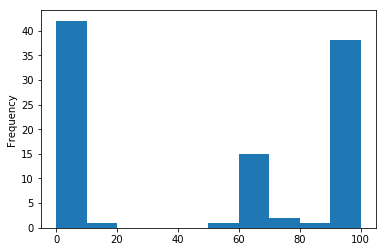

In [42]:
missing_df["% of total values"].plot(kind = "hist")

We can see from this that we have a few types of missing values to deal with. Let's decide what to do column-by-column. 

Firstly, we can safely drop the columns that have 100% of values missing. 

In [43]:
all_values_missing = ["id", "member_id", "url"]
df.drop(columns = all_values_missing, inplace = True)

Now we see columns related to settlement plans or hardship status. These are initiated after a loan is taken out, so we can remove these - this is not data the business has available when evaluating a loan.

In [44]:
is_settlement_or_hardship = df_data_dictionary["Description"].str.contains("settle|hardship", regex=True, case=False)
settlement_cols = df_data_dictionary[is_settlement_or_hardship].LoanStatNew.values
settlement_cols

array(['hardship_flag', 'hardship_type', 'hardship_reason',
       'hardship_status', 'deferral_term', 'hardship_amount',
       'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
       'hardship_loan_status',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'], dtype=object)

In [45]:
df.drop(columns = settlement_cols, inplace = True, errors = 'ignore')

In [46]:
missing_values_df(df).shape

(77, 4)

The next missing columns relate to joint applications. A small proportion of applications are joint applications (1.9%). We have two options with this:

- If there is a significant difference between the default behavior of joint and single applications, creating separate models for assessing the likeliness to default for each application type.

- If there is similar behavior, drop the columns relating to joint applications and consider them as identical to single applications. 

I will defer this analysis to later - if there is time - and for now drop the joint application columns and joint applications to eliminate possible bias. 

In [47]:
joint_columns = [x for x in df.columns if ('joint' in x or 'sec_app' in x)]
df.drop(columns = joint_columns, inplace = True)
df.drop(df[~df["is_individual_app"]].index, inplace = True)

Let's go through the other columns.